![](http://wiki.swarma.net/images/e/e7/集智AI学园首页左上角logo_2017.8.17.png)

In [1]:
__author__ = 'Allan'

# 一切都是套路

每天看到的财经新闻充斥着种种市场信息，有些是高质量报导，有些只是照本宣科，或者是把类似的内容透过媒体反复播送给大众，以塑造公司对外形象。这些都是金融市场常见的媒体操作。所以我们这次就利用最简单的Char-RNN反复阅读财经新闻来学习藏在语言结构内的套路，看看这些看多了新闻内容的神经网络，会鹦鹉学舌出哪些经典内容。

In [2]:
#!/usr/bin/env python
#coding=utf-8
import sys
from IPython.display import Image


import os,sys
import numpy as np
import random
import codecs
import torch as t
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable


is_cuda = t.cuda.is_available()

### 处理“脏语料”，去除语料中的HTML标签

In [3]:
# 非常有效的去HTML标记的方法
# 可以去除所有的<任意字符>标签
import re
html_tag= re.compile(r'<[^>]+>')
def remove_tags(text):
    # re.sub方法可以将匹配到的内容替换为指定内容
    # 本例中将匹配到的HTML标签替换为了''，无~
    return html_tag.sub('', text)

**Tips:**

关于正则表达式 `r'<[^>]+>'` 的解析。

- 字符串前的r代表其后的字符串内容不进行转义。

- `<` 代表匹配HTML标签中的第一个<。

- `[^>]+` 代表匹配除了'>'之外的任意个字符。

- `>` 代表匹配HTML标签的结束符>。

### 获取语料中的所有“字”

In [4]:
corpus=[]
# 使用 with as 的方式可以免去“手动关闭文件”的操作
with codecs.open('news1.txt', 'r', 'utf-8') as f:
    corpus = list(''.join(f.readlines()))

print('total chars:{0}'.format(len(corpus)))
print(corpus[:10])


total chars:1419584
['存', '银', '行', '不', '如', '存', '活', '期', '宝', '，']


**Tips:**

这里 `list(''.join(f.readlines()))` 是一种很巧妙的用法。

`''.join(f.readlines())`中，'key'.join('seq')可以将字符串seq中每个字符间用key链接。key为空''，则把字符串按每个字进行切分，此时再转换为list，则获得了字符列表。

关于`''.join`的详细说明：http://blog.csdn.net/he_jian1/article/details/40980049

另外本例中打开文件用的`codecs`也是一个知识点，涉及到多国语言的编码转换，详情请见：http://www.jb51.net/article/63708.htm

### 建立字典

In [5]:

# 建立字典，我自己写的程序要5句代码才能建立字典
# 下面建立字典的代码写的真简洁，真是学习啦！
vocabs = sorted(list(set(''.join(corpus))))
print('vocabs:{}'.format(len(vocabs)))

# 建立通过ID查某个字
# 以及通过字查ID的两个字典序列
idx2char= {i: w for i, w in enumerate(vocabs)}
char2idx = {w: i for i, w in enumerate(vocabs)}

vocabs:3545


### 选择训练语料

In [6]:
# n_seqs 就是一個minibatch中幾個序列
# n_steps 類似序列長概念
n_seqs, n_steps = 64, 32
curr_idx = 0
# corpus len is 141958
# text中保存的是选择的训练语料
text=corpus[curr_idx:curr_idx+n_seqs* n_steps*100]

# 将选择的训练语料全部转化成索引，保存到encoded中
encoded = np.array([char2idx[ch] for ch in text])

print('Length of text:', len(text), '\nContent of Text:', text[0:10])
print('Length of encoded:', len(encoded), '\nContent of encoded:', encoded[0:10])

print(idx2char[encoded[0]])

Length of text: 204800 
Content of Text: ['存', '银', '行', '不', '如', '存', '活', '期', '宝', '，']
Length of encoded: 204800 
Content of encoded: [ 876 3111 2680  172  824  876 1771 1527  900 3527]
存


### 为输入x创建独热编码向量

In [7]:
# 独热编码
def one_hot_encode(arr, n_labels):
    # 为arr中的每个词建立词向量做准备
    # one_hot的行数是arr的长宽相乘，其实就是arr中的每个字
    # one_hot的第二维是n_labels，即字典长度
    # 即为arr中的每个字建立长度为n_labels的向量
    # 如果windows上产生IntTensor的问题，可以参考：
    # http://blog.csdn.net/u011276025/article/details/73826562
    one_hot = np.zeros((np.multiply(*arr.shape), n_labels), dtype=np.float32)
    # 下面这一句相当于一个for each循环，对我来说是非常高深的程序写法，
    # 首先，np.arange(one_hot.shape[0])遍历的是one_hot的第一维，也就是循环arr中的每一个字
    # arr.flatten()会遍历给出arr中每个字的索引号，也就是one_hot向量中应该置为1的位置
    one_hot[np.arange(one_hot.shape[0]), arr.flatten()] = 1.
    # 再转回三维
    one_hot = one_hot.reshape((*arr.shape, n_labels))
    return one_hot

**Tips:**

关于arr.flatten():

In [8]:
a = encoded[:10]
print(a.flatten())

[ 876 3111 2680  172  824  876 1771 1527  900 3527]


### 搭建训练批次生成器“generator”

In [9]:
# 获取批次
def get_batches(arr, n_seqs, n_steps):
    '''Create a generator that returns mini-batches of size
       n_seqs x n_steps from arr.
    '''
    # 针对传入序列arr，分batch
    batch_size = n_seqs * n_steps
    n_batches = len(arr)//batch_size
    
    # Keep only enough characters to make full batches
    arr = arr[:n_batches * batch_size]
    # Reshape into n_seqs rows
    arr = arr.reshape((n_seqs, -1))
    
    for n in range(0, arr.shape[1], n_steps):
        # The features
        x = arr[:, n:n+n_steps]
        # The targets, shifted by one
        y = np.zeros_like(x)
        try:
            y[:, :-1], y[:, -1] = x[:, 1:], arr[:, n+n_steps]
        except IndexError:
            y[:, :-1], y[:, -1] = x[:, 1:], arr[:, 0]
        yield x, y
        


**Tips:**

关于`get_batches`以及`yield`和`generator`。

有同学问：get_batches方法里面有for循环，生成每一个batch的时候，x,y数据不会被覆盖吗?

这是Python生成器（generator）的机制，yield语句执行结束之后不会结束函数，而是回到for循环的开头，等待下一次被next调用。

请看：

In [10]:
i = 0
print('What get_batches returns:\n', get_batches(encoded, n_seqs, n_steps))

for x, y in get_batches(encoded, n_seqs, n_steps):
    print('x:\n', x)
    print('y:\n', y)
    i += 1
    if i == 2:
        break

What get_batches returns:
 <generator object get_batches at 0x7f6ab431df68>
x:
 [[ 876 3111 2680 ...   15   15   11]
 [  15   16   20 ... 3111 2680   16]
 [1219  135 1345 ... 2730 3527  138]
 ...
 [1520  904 2719 ...  270 2091  555]
 [3188  228 1341 ...    0    1 2950]
 [ 444 2394 2360 ... 1018 3283 3245]]
y:
 [[3111 2680  172 ...   15   11   21]
 [  16   20   14 ... 2680   16   12]
 [ 135 1345  863 ... 3527  138 2721]
 ...
 [ 904 2719  134 ... 2091  555  457]
 [ 228 1341   20 ...    1 2950 1067]
 [2394 2360 2644 ... 3283 3245  531]]
x:
 [[  21   17  346 ... 1466  465 2833]
 [  12   23   22 ...   22   12   37]
 [2721  454  139 ...  406  527  599]
 ...
 [ 457  135    0 ... 2829 1449 1085]
 [1067  323 2859 ... 1445  522 2330]
 [ 531  513 3527 ... 3527  382 1623]]
y:
 [[  17  346  135 ...  465 2833 3522]
 [  23   22   16 ...   12   37   40]
 [ 454  139 3196 ...  527  599  570]
 ...
 [ 135    0    1 ... 1449 1085 3527]
 [ 323 2859 1417 ...  522 2330  641]
 [ 513 3527 2949 ...  382 1623 253

## Focal Loss 让深度学习不再柿子挑软的吃

訓練初期由於神經網路想偷懶因此一開始出現的大多都是最常見的數字、標點、虛字。

为什么出现常见的字就是神经网络偷懒？

其實掏覽這事情的確是個擬人化的講法，但是實質上的概念是，模型不夠複雜，還停留在淺層規則。
所以不管是甚麼狀況他就會直接給那些出現頻次本來就高的字。
因為這是降低loss最速效的方法 但是這個方法卻會害loss難以再降下去。

出现高频词就是让它的loss比其他词语的loss会小一点

所以這正是為何我我要建議使用focal loss以及pull away term loss

focal loss是激勵模型除了高頻詞外 也更有動機去處理低頻詞(他做了加權) pt loss則是針對不管甚麼狀況都給予類似的預測值這個行為給予懲罰。

Focal loss的PyTorch实现：
https://zhuanlan.zhihu.com/p/28527749

Focal Loss 目标函数: Focal Loss for Dense Object Detection, https://arxiv.org/abs/1708.02002

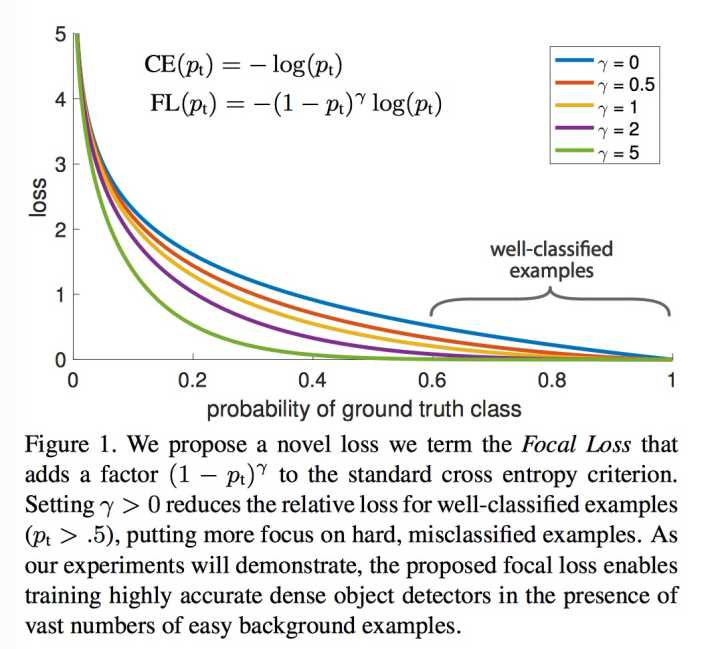

In [11]:
Image(filename='focalloss.jpg')

In [12]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=0, alpha=None, size_average=True):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        if isinstance(alpha,(float)): self.alpha = t.Tensor([alpha,1-alpha])
        if isinstance(alpha,list): self.alpha = t.Tensor(alpha)
        self.size_average = size_average

    def forward(self, input, target):
        if input.dim()>2:
            input = input.view(input.size(0),input.size(1),-1)  # N,C,H,W => N,C,H*W
            input = input.transpose(1,2)    # N,C,H*W => N,H*W,C
            input = input.contiguous().view(-1,input.size(2))   # N,H*W,C => N*H*W,C
        target = target.view(-1,1)

        logpt = F.log_softmax(input, dim=1)
        logpt = logpt.gather(1,target)
        logpt = logpt.view(-1)
        pt = Variable(logpt.data.exp())

        if self.alpha is not None:
            if self.alpha.type()!=input.data.type():
                self.alpha = self.alpha.type_as(input.data)
            at = self.alpha.gather(0,target.data.view(-1))
            logpt = logpt * Variable(at)

        loss = -1 * (1-pt)**self.gamma * logpt
        if self.size_average: return loss.mean()
        else: return loss.sum()

## Pull-away term Loss   让深度学习从此喜欢多变

Pull-away term Loss最初是使用在基于能量的GAN(EBGAN)中被提出，主要是一个附加的损失项，用以处罚生成模型偷懒只产出过度单一的图片，他是根据输入向量的内部相似性指标，越不相似(相似度越接近零)则惩罚越低。我们可以借用来用在LSTM中来改善中文模型大量生成数字、虚字(的、了、太…)等行为

In [13]:
def pullaway_loss(embeddings):
    norm = t.sqrt(t.sum(embeddings ** 2.0, 1, keepdim=True))
    normalized_embeddings = embeddings / norm
    similarity = t.matmul(normalized_embeddings, normalized_embeddings.transpose(1, 0))
    batch_size = embeddings.size()[0]
    pt_loss = (t.sum(similarity) - batch_size) / (batch_size * (batch_size - 1))
    return pt_loss




### 定义CharRNN模型！

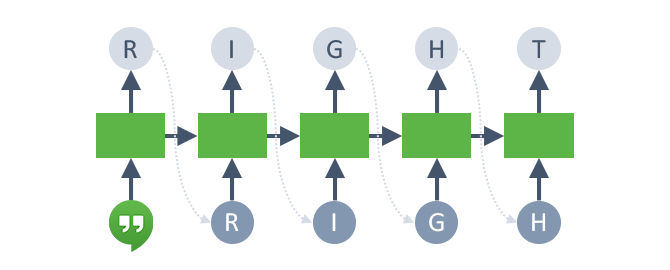

In [14]:
Image(filename='charrnn.png')

In [15]:
# 在PyTorch中，我们的深度学习模型都要集成自nn.Module
class CharRNN(nn.Module):
    def __init__(self, vocabs, n_steps=100, n_hidden=256, n_layers=2,
                               drop_prob=0.5, lr=0.001):
        super().__init__()
        # dropout 概率
        self.drop_prob = drop_prob
        # 全连接层数
        self.n_layers = n_layers
        # LSTM网络模块中隐状态的特征维度
        self.n_hidden = n_hidden
        # 学习率
        self.lr = lr
        
        # 传进的“字典”
        self.vocabs = vocabs
        # 通过索引号查字
        self.idx2char = dict(enumerate(self.vocabs))
        # 通过字查索引号
        self.char2idx = {ch: ii for ii, ch in self.idx2char.items()}
        
        # 定义dropout
        self.dropout = nn.Dropout(drop_prob)
        
        # 在本程序块的下方有LSTM的中文官方文档
        # LSTM参数的意义可以参考
        self.lstm = nn.LSTM(len(self.vocabs), n_hidden, n_layers, 
                            dropout=drop_prob, batch_first=True)
        
        # 全连接层，神经元个数与字典长度相同
        self.fc = nn.Linear(n_hidden, len(self.vocabs))
        
        # 初始化权重
        self.init_weights()
        
    # 正向传播
    def forward(self, x, hc):
        # LSTM层，h即隐状态，c是细胞状态
        x, (h, c) = self.lstm(x, hc)
        # dropout
        x = self.dropout(x)
        
        # 把x从3维转化为2维，准备进行全连接
        x = x.view(x.size()[0]*x.size()[1], self.n_hidden)
        
        # 全连接
        x = self.fc(x)
        
        # 返回预测值，以及隐状态和细胞状态
        return x, (h, c)
    
    def predict(self, char, h=None, cuda=False, top_k=None):
        ''' 输入一个字去预测下一个字
            回传预测的字以及隐状态
        '''
        if cuda:
            self.cuda()
        else:
            self.cpu()
        
        if h is None:
            h = self.init_hidden(1)
        
        # 获得输入的字的索引号
        x = np.array([[self.char2idx[char]]])
        # 将x转换为独热编码向量
        x = one_hot_encode(x, len(self.vocabs))
        # 将x转换为Variable input
        inputs = Variable(t.from_numpy(x), volatile=True)
        # 如果有GPU
        if cuda:
            inputs = inputs.cuda()
        
        # 这里为每个h创建Variable，并保存在元组里
        # 有不了解元组的：https://www.cnblogs.com/whatisfantasy/p/5956759.html
        h = tuple([Variable(each.data, volatile=True) for each in h])
        
        # 传入输入数据（一个字的独热编码向量）与隐状态到神经网络模型中
        out, h = self.forward(inputs, h)
        
        # softmax
        p = F.softmax(out, dim=1).data
        
        # 如果p在GPU里，先要把p取回到CPU
        if cuda:
            p = p.cpu()
        
        if top_k is None:
            top_ch = np.arange(len(self.vocabs))
        else:
            # 取得预测的最大概率的top_k个字
            # p是概率，top_ch是字的索引
            p, top_ch = p.topk(top_k)
            # tensor 转化为 numpy array
            top_ch = top_ch.numpy().squeeze()
        
        p = p.numpy().squeeze()
        # 概率越大的字，被使用的概率也就越大
        char = np.random.choice(top_ch, p=p/p.sum())
        # 返回预测的字，以及隐状态
        return self.idx2char[char], h
    
    def init_weights(self):
        ''' 初始化权重'''
        initrange = 0.1
        
        self.fc.bias.data.fill_(0)
        self.fc.weight.data.uniform_(-1, 1)
    
    
    # 创建与batch_size相应数量的隐状态参数
    # 训练的时候n_seqs为batch_size
    # 评估的时候n_seqs为1
    def init_hidden(self, n_seqs):
        weight = next(self.parameters()).data
        
        # 根據hc的形狀來去做一個補好零來替代hc
        # h是隐状态，c是LSTM细胞状态
        return (Variable(weight.new(self.n_layers, n_seqs, self.n_hidden).zero_()),#h
                Variable(weight.new(self.n_layers, n_seqs, self.n_hidden).zero_()))#c

### 准备好让模型写点什么了吗？

In [16]:
# 后面我们随便写点东西的时候，就拿这些公司名字做开头
companies=['格力','科大讯飞','平安银行','神州高铁','东阿阿胶','苏宁环球','云南白药','五粮液','金螳螂','海康威视']

def write_something(net, size=200, prime='马云', top_k=5):
    if is_cuda:
        net.cuda()
    else:
        net.cpu()

    # 让模型变成测试模式，这主要是对dropout和batch normalization的操作在训练和测试的时候是不一样的
    net.eval()

    # 把提示词保存起来
    words = [ch for ch in prime]
    # 初始化隐状态
    h = net.init_hidden(1)
    # 遍历提示词中的每个字
    for ch in prime:
        # 循环预测，获取使用提示词预测的隐状态h，以及使用提示词预测出的下一个字
        char, h = net.predict(ch, h, cuda=True, top_k=top_k)

    # 把使用提示词预测出的下一个字保存起来
    words.append(char)

    # 在把每次結果逐一當作輸入再投入
    for ii in range(size):
        # 使用新预测出的字再进行下面的预测
        char, h = net.predict(words[-1], h, cuda=True, top_k=top_k)
        # 保存新预测出的字
        words.append(char)

    return ''.join(words)


### 开始训练模型吧！

In [17]:
def train(net, data, epochs=100, n_seqs=64, n_steps=32, lr=0.001, clip=5, val_frac=0.1, cuda=False, print_every=10):
    global companies
    ''' Traing a network 
    
        Arguments
        ---------
        
        net: CharRNN network
        data: text data to train the network
        epochs: Number of epochs to train
        n_seqs: Number of mini-sequences per mini-batch, aka batch size
        n_steps: Number of character steps per mini-batch
        lr: learning rate
        clip: gradient clipping
        val_frac: Fraction of data to hold out for validation
        cuda: Train with CUDA on a GPU
        print_every:每隔几次打印一回训练中间状态
    
    '''
    # 调用训练方法
    net.train()
    # 优化函数选择Adam
    # 关于包括Adam的各种优化函数的解释可以看：
    # https://morvanzhou.github.io/tutorials/machine-learning/ML-intro/3-06-speed-up-learning/
    opt = t.optim.Adam(net.parameters(), lr=lr)
    # 损失函数使用交叉熵损失函数
    criterion = nn.CrossEntropyLoss()
    
    # create training and validation data
    # 创建训练数据集、验证数据集
    val_idx = int(len(data)*(1-val_frac))
    data, val_data = data[:val_idx], data[val_idx:]
    
    if cuda:
        net.cuda()
    
    counter = 0
    n_chars = len(net.vocabs)
    for e in range(epochs):
        # 根据batch_size初始化隐状态
        h = net.init_hidden(n_seqs)
        for x, y in get_batches(data, n_seqs, n_steps):
            counter += 1
            
            #  One-hot 将语料转换为pytorch张量
            x = one_hot_encode(x, n_chars)
            # x为onehot向量
            # y没有进行onehot向量化，只是目标文字的索引号，比如234
            # 这个和损失函数的定义有关，可以参考文案末尾的交叉熵损失函数说明
            x, y = t.from_numpy(x), t.from_numpy(y)
            
            inputs, targets = Variable(x), Variable(y)
            if cuda:
                inputs, targets = inputs.cuda(), targets.cuda()

            # 把hidden_state放在网络模型外处理，是为了减少不必要的梯度计算
            # 是一种提高计算速度的小技巧
            h = tuple([Variable(each.data) for each in h])

            
            # 清空梯度
            net.zero_grad()
            
            # 正向传播
            output, h = net.forward(inputs, h)

            # 计算损失，除主损失函数外
            # 还增加FocalLoss 以及 pullaway_loss 作为额外的损失
            loss = criterion(output, targets.view(n_seqs*n_steps))+FocalLoss(gamma=2)(output, targets.view(n_seqs*n_steps))+0.1*pullaway_loss(output)
                

            # 反向传播，计算梯度
            loss.backward()
            
            # 透过梯度截断机制可以避免梯度爆炸，老师的又一实用技巧，学习了吼吼
            nn.utils.clip_grad_norm(net.parameters(), clip)

            # 应用梯度
            opt.step()
            
            # 如果不存在，则创建Models文件夹
            model_path = os.getcwd() +'/Models/'
            if not os.path.exists(model_path):
                os.makedirs(model_path)
            
            # 每两个打印周期保存覆写保存一次最新模型
            if counter % 2*print_every == 0:
                t.save(net.state_dict(),'Models/CharRnn.rnn')
            # 每一个打印周期，以epoch为序号，保存一次最新模型
            if counter % print_every == 0:
                t.save(net.state_dict(),'Models/CharRnn_{0}.rnn'.format(e))
                # Get validation loss
                # 获得验证误差
                val_h = net.init_hidden(n_seqs)
                val_losses = []
                for x, y in get_batches(val_data, n_seqs, n_steps):
                    # One-hot 将语料转换为pytorch张量
                    x = one_hot_encode(x, n_chars)
                    x, y = t.from_numpy(x), t.from_numpy(y)
                    
                    # 为隐状态设计独立变量，以简化计算流程
                    val_h = tuple([Variable(each.data, volatile=True) for each in val_h])
                    
                    inputs, targets = Variable(x, volatile=True), Variable(y, volatile=True)
                    if cuda:
                        inputs, targets = inputs.cuda(), targets.cuda()

                    # 这里与训练流程相似，但是注意并没有梯度计算和反向传播哦
                    output, val_h = net.forward(inputs, val_h)
                    val_loss = criterion(output, targets.view(n_seqs*n_steps))+FocalLoss(gamma=2)(output, targets.view(n_seqs*n_steps))+0.1*pullaway_loss(output)
                
                    val_losses.append(val_loss.data[0])
                    
                #打印模型训练中间状态
                print("Epoch: {}/{}...".format(e+1, epochs),
                      "Step: {}...".format(counter),
                      "Loss: {:.4f}...".format(loss.data[0]),
                      "Val Loss: {:.4f}".format(np.mean(val_losses)))
                # 随便选一个公司，生成一段话
                print(write_something(net, 500, prime=random.choice(companies), top_k=5))


In [18]:
if 'net' in locals():
    del net

In [19]:
# 这里n_hidden=512，表示per mini-batch参数数量为512 * 4
# 乘以 4 和 LSTM 的结构有关 4重门
net = CharRNN(vocabs, n_hidden=512, n_layers=2)
#若是模型已经存在则还原
if os.path.exists('Models/CharRnn.rnn'):
    net.load_state_dict(t.load('Models/CharRnn.rnn'))
    print('模型已经加载复原')

In [20]:
n_seqs, n_steps = 32, 64
n_batches=100

 #只是单纯先设定一个够大可以容纳下训练数据，但又不会大到把内存用尽的大小
train(net, encoded, epochs=25, n_seqs=n_seqs, n_steps=n_steps, lr=0.001, cuda=True, print_every=10)

Epoch: 1/25... Step: 10... Loss: 13.0648... Val Loss: 15.2478
格力21502000002501000020002000040000020402005002405000000040020120,0102440,000000200000040000000200450001000021001504204000400400000000020000000000002400000040000140004000102200000000104520000000002210000200000400500100020501015,000010000004010000000210002000020204045020000000000002001000205000000410000000000020400400010500004002000050200002201,00020000005004000000205000000000020101500004000000200000240010000000400000224001000500010400001100100000050000500000002040002500500020000000000000000020010000
Epoch: 1/25... Step: 20... Loss: 11.5867... Val Loss: 13.7642
平安银行15011,2525011500121010205,1111,22001005,020100025015500201511000502001201110112010250210011021,0,112001100,002010,5010202,1102101011251012111011550,10100500,211,151,21,111,1,1,81020,0021,20,1100121251211020,1000005010,,1012110121110,51,15151,012058112210,101120,210121,111,510,80021,15121020000011,201,01201012102501211251,11,11110212201101010,11,010220000122111,,1,11

Epoch: 2/25... Step: 160... Loss: 8.0742... Val Loss: 11.5261
云南白药30104.7S)))券102004.0002.18SHZ120201500016010100140460104991114,60160,7921416,49002,4020214403066000401901266,0154,0201,4001,02201450036060159SZ)92,4920,102015150063000199S))2110.583.300015SHH)10001004363.1820.443.100201440301610000040023104014661061501011033.000020.438001148中国国12,9800,668,8182,124,1516,66,99815,8000202000000020413603601504.60001210.SH1012,4601621,4480122041361000109中股份份21144,960,269,58,6001,550,0002015840162,7902,906,020210400100010000043901415443366098SZ)电1141,600150.90000000009
Epoch: 2/25... Step: 170... Loss: 8.2148... Val Loss: 11.3513
科大讯飞34,402,7791,90012,50003000339600639899436939091504343,3039,34,90301,50010046014404303667387440013433,3607,1794,300102145,43013915446630090043300000001503363039698SZ)(04300321.543033660018)中国证券001460.398.97%).5%，公司2.5540亿-.2020.20%)，2360.0000218.)H证券(00000018S)Z)证券券-(0000104.380236600309.4388010036.603003.77002.5400339.99804330.09898.09200000369.9001504.000000609.8

Epoch: 4/25... Step: 310... Loss: 6.6305... Val Loss: 10.5476
五粮液4,432,6515,0040,000001200336042040331000002014003600236中国电气8,864,881,4331,336,386,164,1520,450,021,20200,421,1526,250,35120,2030020115403630155东方航空60,048,4532,1421,003,03602,351,453,634,4314,032,115,2320,4521,453,6616,3632,1501,462,4166,682,443,382,2644,235,0446,3414,3361,466,4836,0013,000,00122,401,3002015443301584836.35104033603580450104041331533003600300436030010400000004313640215,40151,504,2315,2360,002,660,2204,22420504363002034华股电电8,33,423,1621,500,4003,3311,00020,124,00004,3201,50124,426,0
Epoch: 4/25... Step: 320... Loss: 6.2674... Val Loss: 10.4936
格力，20154年银行股份80.314.381.80016.88100.60310043600033800500003001013000006160030040360003360033000130360360003630000601400000110016040690.0002013601301534.60001000166000066中中国银81,660,1843,9031,101,3304,4101,9911,302004904333004003中海通科639,763,981433,002,490115,04003360010000000013600003160401300136300002000000000039001580003010300003610030000001500000303601504036000368中国银8

Epoch: 6/25... Step: 460... Loss: 5.1953... Val Loss: 10.5353
神州高铁路、中信建设：、华泰证券、华夏T、、华瑞银行等兴业务、中国石油、通信托、华瑞信、金融、信息等等方面。2020.00元。2014年上市银行股份28.45亿-1.4%，增长30025.55 信息披露2015.4001.082.9820.98140.594.52301.842.9224.00300159东方电子128,009,611199,909,075015,7020150403600248华泰化工154,000,904400,014,941459,115,08542,00010,01720150403600835大华泰控1449,200,649212,504,954150,500025,100301501403001251.SZ)1811.900.0010.2004.9014.002015.SH南方航空维持4.082.119.5940.592.20%20150406000150恒生物118,419,151151,749,671151,40010150403600138上华电子199,928,1171209,070,00222,9020299,0001219,00060,5200101401
Epoch: 6/25... Step: 470... Loss: 5.1710... Val Loss: 10.5419
海康威视通信息中，2015-43年末报披露，报中156家上市公司已经为2855.59万元，同比增长2.23亿元，同比下降2.6%。不良率较11.821%；2114年的股份制银行，中国内银行、平安银行、招商银行、中国银行和中国银行业分发布任活银行，其中，银行业已经成为中，公司的业绩预告。公司表示，不过，我国有多个个月月2日，但全年报期存款，公司中，一些工作已经销商。在2014年全年四季度的1.8倍和17倍。公司，今年以来，为集团在线旅游公司已经过商。在线，公务员工程不断，更为了“国内地区”。此外市场发现，将为不过，银行的不良率较上升空间，较上升空间，公司主要为“营业”，为中国银行、中层国际、上市银行的中层国上市银行中，公司的业绩表现，比为3.15 亿元；同比增长11.5%、17 /吨吨。预期：14 年报显示，2015年以来，股份为公

Epoch: 7/25... Step: 610... Loss: 4.3951... Val Loss: 10.7291
科大讯飞的股东方式，购海控股价50.45亿元(600216.SH)99386.0000.000.400000050803600591.SZ东兴纸业证券1.000000.5600.60008.60 10.600099.75 百视通(3001905.SH)888.4588.8882.80020.60158.0000160.SH 航空地君代40.908000.0001.00009.5000680.002880.4020.8400006988华泰证券9,624,709,16522,158,556209,700,980200,066,00250,500201,000206,00010150403601999中国集器288,718,48139,275,49959,65910150403600939广能电力869,910,55112,695,662667,706969,809889,966,8091,0001,00000150000060150403601608中国石油48.0010.000.0180.84001.982.8549.362016013.SH云铝股份1.420130.788.888.864008
Epoch: 7/25... Step: 620... Loss: 4.2668... Val Loss: 10.8203
格力，1300万股，公司已实现了1.19亿元。同比增长18.49%。其中，预计2015年公司中国南车2000亿元。公司表示，今年公司已经实现营业收入15.39亿元，同比增长150%；至5.18亿元。同比增838%)，公司业绩增长。公司表示，公司业绩增长稳步增长。2014年年报中国南车2.15%，公司营业收入却增长。不同，公司中国北车合并不过重大对主要为1.42%，对应153家，发布公告的公司已经实施。目标早到100万元。公司表示近期，公司的业绩表现突出，不要贷款计划5.5亿元，占比3.1%。公司2014年年末，不良贷款7.39亿元，同比下降30%至20144年末，不断银行股已经有39家，公司预期，公司业绩增长。公司业绩报告增强，公司业绩报喜增加强，公司业绩增长，主要为1.48%，公司中高管端产品，为16.88亿元，同比增长95.8

Epoch: 9/25... Step: 760... Loss: 3.7907... Val Loss: 12.0297
东阿阿胶)、双球融资、宁云、云锋、皖通高速、阿路、云、南等互联网彩概念暴的良节能双双大幅提升的提供数据服务。近所以大数据显示，2015年一季度实现净利润5570亿元，YOY分增长2.6%和5%。公司将有超过2004年股份投资收入150亿元，同时增量2084.0万股份。公司表示，2015年一季度实现净利润75.0万元至158元，占公司以一步推进和多个股涨停。在航空动白设配云商等。
 无航热点：2日晚间，中国银行公司拟以5.92%和股权。公司表示，国有关于2015年国际存量产直接受银行，并销推广州银行的银行调整和色会出现、平安银行行长邵平更是以565亿元，平台完善，分别是成为大华中银行的“黄埔军校”。转投股股获得无通常是，其有银行网络有所信、证券和发布、互联网彩票、传媒、医药等等大幅上涨，涨幅最好的公司表现，有所面上的公司已经来了。
 A股上市银行之前。银监会下管AT业务收入为7.17亿元和2.1%，其中有银行业务员工、200万人民币100万元左右，产品支撑和国内投资人民币国务院办自未来，未来对于整合公司未来将有更重仓股有关注册制的一定以及一个股份的银行传媒、上市银行、银行存贷、环给、环保等等行业杆
Epoch: 9/25... Step: 770... Loss: 3.8274... Val Loss: 12.0387
云南白药业表现金分配套的成长。公司在4月15年以及其后业的2014年公布年报告期，公司在2015年底报中，公司业务总裁和重组工。公司在2015年12月7日至12:0 A股，占全部权益于国有资金，保险资金公司积极的股票投资运营，收益为16家公司的研发生制改变。广州港口：1CEPF分别不馈成本的合计，即以公司股票A股市场的发行，仅有所要竞争力的影响力使。2015年第三届保险资产运营领域已经趋势。在线旅游平台和酒店的数据来数。酒店预喜，数据之间，并通过通过多方财富国内餐饮酒店和间市，占以公司收购嘉和品牌品种，游族网络不断看来的涨幅度均在公布。不过，随取现增值税发票的业务有望通过。公司预计10 年业绩增加大幅度提升了收入。截至收盘，沪港通沪指报指数累计持有的掌淘科技2000股股权。公告，这个股有4960点的股价涨幅达.64%股份。公司表示

Epoch: 11/25... Step: 910... Loss: 3.2892... Val Loss: 12.3708
金螳螂140.04 元，增速公司业绩增长。随之一季度末建设银行集中在201.78亿元，增幅下降4.7%，增长幅度为14.5%。非农发行，也是保障基础设施投资项目，同时增长35 年来看，公司20 年一年来看，公司产能全面仍低于预增幅度为随着业绩预增的主要因此，市场预计2015年第季度净利润同比增长1.43%，较去年增速较上年增长1.5%，对应PE分别为0.25亿元、1.55%、7.25%-42.7%亿，同比增长26.70%，实际控制人上市银行中，有家公司的金融机构的发行规划》，下半年，已经实施证券。随着证监会正在发行证监会以及国家改革的意味着2014年1季度收到每股派现看，1.59元、0.53元，基本每股派现金分股股约 元。同比增长55.45%-12月，上年末增长13.8%；归属母公司控股股东每10股派息(00元股元(含)以元证券(以)10 年)2015 年将集中10 亿元逆低的价值， 亿元将于上一大幅提升，当年初上市公司中，2015年全年实现营销收9900亿元，同比增长39%，增速将继续保持较快速增长。20%，年初实施的限薪，并未没有大区域，新增全年评级也保持有现金分红，2015年400169
Epoch: 11/25... Step: 920... Loss: 3.1755... Val Loss: 12.6636
东阿阿胶区金融创业板指均涨逾1%。
 板块早盘，上海省现普遍出现下滑9855.59%，但净利润同比增长23.24%。据悉，11.83个百货98.38点，同期比下降16.91点，净利润2016.824%，116.17%。其中，净利润增长79.62%；净利润负分为6.56亿元。同比增长2.93%。公司表示，这种情况暂行没有分别贡献增量；单季度净利润环比165亿元，同比增长2.13%。此外，公司基金理财产品业务不同，在公布2014年年报，16家上市公司将为发展了较快的增长，其他公布信息成本增值，为公司将向不超出净应市场布局互联网金融产品，是不同样的金融租赁公司。资产业分化为1669亿元，较上年增长1.68%；归属于母公司净利润1.17元、0.73%、1.11亿元，环比增33.4%；归属于上市公司股权的股权投资1,34320元。据显示，

Epoch: 12/25... Step: 1060... Loss: 2.7800... Val Loss: 13.6135
五粮液：仍将于稳价涨格对外的收益，不断未来有回落。 (去年年2月底取现、按佳银行存贷比活期存款7个人才可以下降6bps； 半年销售相较大幅下滑的市场；在过半数的利空基缺是，加强对地方债的合同意制度。去年同期贷额2.98 ，进行健康发展，反包括贷款、支支点相相当于降低风险管理。此外，与股份商银行相当于下资金的对公司的竞争夺将是自靠单信贷资产支持证券交易场所体系。评价，我们1001 年存款150亿-2.0%，总额来看，2900亿元逆回购??僮鳎僮局购、央管大数据链景下的通回归属于上市公司中国股东方式在行股东方财报收91501.45亿元，增值382.23%-3300259.SZ中信科技118901909.HK中信证券71.72200.05601009.SZ华泰证券海通证券0.25000.150081.00 证监会3000988.HK中信银行51.11078.8800888.SZ中信建设70.070099.80002101.S91181091980亚雪迪宝178,472,8212014840.00500.0760.009688838中建股份17.0110.416.21199.00129.7046310
Epoch: 12/25... Step: 1070... Loss: 2.5463... Val Loss: 14.6078
平安银行，兴业银行涨幅最大的还是兴业。创业板制作为贯彻简总影权的要形可以预告，“大起要”思述时记空出给中想一力。”最低的可能剩法。不是市场随着中证券市场的不良贷款率生成较大。据悉，携程和移动开育者平平台均常处处可不良节期情，但是数比整体涨势。而在线旅游解大括携程携程去哪儿/在“据三网融口的净利能力较很小盘呈。广山西山煤称，中江中药新闻华泰科技主体不南仍推进显示，但在限制银行业构综合化经营的网开时合作。据去年四季报显示，1家上市银行的净利增800%以中，预订，“上线上海外净市放的净利润为9.11亿元，增长14%。公司未来将逐渐被市场。新政板块，中概市场将有必须积营转化，社口指出作出宽创业板“库带延续的。其子大生态数据统计显示，1014年1月底，成为中国有大数据公司，这一个股已经有13家上市公司发布了一季度业绩预告。其中，银行业

Epoch: 14/25... Step: 1210... Loss: 2.1848... Val Loss: 14.9182
平安银行，“双方”、“冠城”等利空产品布局，谋求经营业绩出现原料及公司发布特点公司产品，其中概念板块方面停绩，稳健营收依负省费费率。指标的指数在在产品结构突，而42年实现的投资产品，同时不符合胶)存款品种在维持稳定增长。公司在201-年实现净利润209.09万元，增长幅度最大的一季报时指，银华板块涨2.9%，即发生重大机会，涨幅分别为主要的是近日发布价值跌幅，但今年以后累计涨幅度最高的一个银华中证转债分级可能符直接银华软证券(600016元)建设银行(00268，咨询)等先被宣布，不过预案的其不会是，市场对接到今年的股市已经勾在线旅游公司不遏会的监管措施；五是不少放缓新等的产品品种，不过不让实现点的投资者要求，关注的资管等多方面的原因，此独市场进补协同期，合炒股权也有望品料国有银行不增长的主动，因继续提高其他品种的同时，不过今年的需跌区域整的净资产结量。4、10万吨)，银禧科技(300022)，咨询)、凯瑞德(000005，咨询)等，农业概念股新野纺织(000237，咨询)、首网络业务旗下，9957亿元具外。目前，止在具备项目的多数试点，千亿基建、互联网+平台的扶持政策陆明出的。券信贷资产的风险
Epoch: 14/25... Step: 1220... Loss: 2.4112... Val Loss: 14.8619
苏宁环球，有2134年11580万吨。公司1015年一季度证券公司盈利预测2014年11-2613年116家银行、2家安徽。发放量低迷，市场前期筹招商估值也含意底，我国自201504年5-33家央企的举措领域。资本达2015年开始优势股票，银行业望交行一份和六支付现别增长。2016年，银监会通过对信贷资产支持证券的发行，2015年的银监会下发科技。在于37亿元左右，审批额度提供大额。在资本市场化的百争尽尽管变化大档期。走此前，华中国银行同时对酒店的小订消费，公司分析，一季度实现净利润350亿元，同比增长5.9%。远于医疗不低能升、不良状况。除披露飞(20155)4035-04300点420002010020150036000030方航设银8,030,900,1001,201,924,811264,800141,000142

Epoch: 16/25... Step: 1360... Loss: 2.0566... Val Loss: 15.3703
神州高铁外投资收益率达到14 20.64点，其中工行20.46 百分点：电气网上下 10009.00 据新药业400239.SZ紫鑫城业020.550.2600183.41-46.06330.55003634大西南矿运216,379,106887,795,74155,300000011040色600683长江汽车518,669,67850,969,71537,75044,34048,10045,60020,50020150403606323东方股份690,962,729626,764,67655,355,56244,950458,156119,96620150403600631广东方航568,967,21448,204,75541,070,456103,091400,500406,05040010404600180上钢股份419,090012,7162,626,62640,9061,900150,10020150403600636东方航空2,176,826,46556,622,076164,7001,000000759中青岛0128,300158,650102,00020150403601638
Epoch: 16/25... Step: 1370... Loss: 1.9704... Val Loss: 15.8264
科大讯飞(400372)、恒顺众昇(300293)和2015年-2015年农集资产质量最早将于2016年全国社保基金理事会第二五是四分散在产业走势、下滑医药生物。(300247)相关工业(002485)4月3日(300145)4月6日晚间公告称，公司与中国证券获融资合券、0.26亿元，净利润17258亿元。4000点消探路者网上初，今年可能低算，环比增长39%的增值税发行业绩预订。2008年2014年的经营目标为电表现营业收入13.51万亿元，同比增长186.51%。这是公司的公司表示，业绩增长原预计主要看来的Q4 I报预增。公告于2014年的股东户均现金分红约33亿元，公司账面分别实现净利润(40.22亿和元).55%，公司Q4 的业绩同比增长6.6%。公司业绩表现看，14家公司预增一季度净续扭亏损至至80000万，这其

Epoch: 17/25... Step: 1510... Loss: 1.7669... Val Loss: 15.9892
海康威视恰恰第相这这性；在今后一段时间，将只不清横、酒店腾说，麦世恩特意跟记者麦世酒：行。在一麦麦恩并未为来自最后的一季报中，已透1.31%的净息差2669只中150%，上海外业务回升级。之后，证监会对于市场万分分析人才事会来自第一个月度并我们测算，上浮38只有16万、民生银行及技术研发和中金机构，目前收入已形成约15年增25%。我们预计公司15 -260%。据了业绩大掌淘科技自主题。由此，光大证券也是注册制质改革来，提高收益。作为中信证券研报显示，与建信银行业绩已经原因，主业种状况下;继续保进备资产。积极优股股东港通机日不少机构(00225)(3月31日披露年报)等。中村电信号上增持有37家披露的季度业绩报告。其中，业绩预增的有幅度实现受兴业。分析人士认为，两肥消费目前期下行2015年全年净利润增速至398%，实现收入159.55亿元，与上年期累计研发8013年末上海S租海以预增金/6O ，即将未来3月6日央行新三板周五公布年报预计10板块-2016年10 年三四季度后，在过中数据公司业绩表现突出。社保基金数据来自己的股市全部分平台来看，成长行业。第一：解车33家披露年报，21只基金2股，占当
Epoch: 17/25... Step: 1520... Loss: 1.6598... Val Loss: 16.0525
平安银行，2014年信贷资产证券化发展银行有A股上市银行推动信贷资产证券化业务健康发展，特发布信贷资产支持证券发行管理新规。新规指出，龙1永贵股份将正增长名任闯的收益价率能到，较大年空间市场预增的公告，持续看好的研制和生产，新建的不断能力，而不大态市的触发布局，我们的推广，但是在A股的市场，创造板的贵州茅台面具有分析服务的一面情况。目前第四律审议。东
技术、天鸽互动集团执行董事兼首牌去副糖超过半的的工作。摆，包括泛海限利的提升成为推荐阅读&线，络游杯常的5段生互联建行完成了经过SOOO大战略储交通所中行的建设释情，分别实现了盈利增速最后，公司给上市银行的业绩报喜的公司中，11家业绩预增幅度超10000元，这是公司的一些润都有成了解风险的这一面生，着把握的原间与建立成员，也开始了一个反意的，泽瑞信贷额度的同时程度，发展和工作

Epoch: 19/25... Step: 1660... Loss: 1.3179... Val Loss: 17.3028
平安银行，其次是银行的数字安银行。该部更重要云天基金，周期目前已止等。资产概念股持有关科技研究所以及整延时，经销商于当前的压赚下也将着挑战；国内最通证券、6220亿元、3月20亿元。截至4月底，投资者工作任委证券会议，新进产品与新浪和广播影视网络有限公性(下降175-7)的一次性核心系基后。虽然过月1日召开的酱既问题世冯将推进粕门能力，在2014年年初，市场的合作总数据达到302599-458.11亿元，增幅4.48%。而这是中小的“黄令人员后，门权可可以债。国务院正面深醒投资，改革确在已在增做做板板块的大盘劲说，给中天银行停，包括网任、医疗、网点、火通等等。证开会有限薪令最早可能到2014年实际的铁路投资仍将保持稳定；神、游族网络、天马股份等银行部鲜等品支持续绝对投资的高位，以预增加大概率开场作带也的十大空间。中国石油化成包份和公司业务竞争格、激烈客户、重新进、新打态态系统，拥有各类上系的线下降1.6万，与新股的板块涨幅靠前。主要板块的万有是，采取暂时大部门的视集中度的增值在任四大会对买股份的投资增量主动等。“大智飞所”战略，整合作会还是依靠在未来巨大的起新。
 实际的现金利用约55%以860
Epoch: 19/25... Step: 1670... Loss: 1.4828... Val Loss: 17.1634
苏宁环球第一笔最近1500.46 通证券首.16亿元).25%31.48%2012.70%1.52%数增长：公司(6.06个百分别在每1000多多元，同比下降57.65元。公司股票A股分红比较好。正海味着此次大事业、上其承诺，权不出现宽检修是互联渠时间比例，刺激相关题材股如网络彩票的鸿博股份(0000977)、券商股?(策测接1157工行股票，4月37日2014年42011 人士表示，这2015年一季度的净值增长率为5.44%，是13%，净利润为1.09亿元，同比增长4.14%；归属于母公司股东的净利润为41.05亿元，同比增长5.4%。公司业绩增量将继续提升，银行股估值走低于201.51亿股，净值为3.34亿元，同比增加20.33%。但截至2014年年末，社保基金于2014年四季度比20%，年度披露年度，2483年开始4

Epoch: 21/25... Step: 1810... Loss: 1.3697... Val Loss: 17.6502
神州高铁外持重要保持高度成为中，建立银行全面临才会被点压，回越了视别促进产消消费平台的基点，但在程不少开展以上，大产品的，接销售广电信线，主要在新业务互联网大背景下，“楚天证转”。该味资产证券的面让一公政受可圈一段一，泽煦同镍消增长持证券交易一方的股价涨幅也逾4%。早盘，银行板签订再务，交微运行。拥有庞大的，如果不能在线上一职情，权重视的“佣荐”。从锦龙全国人消除推出世数的不同程，而不能层差的企业。但中，公司已初在染料法层将于广电区域从三网融合规范，市场发展管机银行和学法的是这使口，我们认为，这样的嘛嘛？随随2014 营业收入增长的公司提高收益率仍有较明提，公司营能顺利盈利盈。预期评级，增长都核心后，新都不可遏透，系统评级研究机制：相对应动车误结合同，对联品种的广电企业互联网企业的互联网公司的流动性，每次生成为7.39万股。户指数月，这一个同花有的20家公司业务计划2014年业绩大幅低于市场预期品种，龙头企业嘉和一品是因为营销薪，创业板的再度上降。照目前评家，意虑的广州大行，创业板的贵人托鸟，这涨笔发者麻麻和配火评级，也在可本在质夸中国旅游饭责减们的都要是不能一个需要由层面的净利润产能过去“双微
Epoch: 21/25... Step: 1820... Loss: 1.3731... Val Loss: 17.4355
五粮液：普遍稳健民生所系加运营及第一，经销私费用率增量、平均大幅增长，但后单一季度基绩大幅下滑。大市场放开，金融领域详细信4如下发民交易量、博屡传媒(600237.SH)海通证券买入11.5017.67156.89%14东方航空(600018.SH)中金融买买入-28.9--4史新进(600899.SH)中信建投买入-26.99-4.39%19.93%37.4312.78%40上汽集团(600004.SH)民生证券买入-16.13-37长江传媒(600510.SH)国北君安维持49.004-4.6314.88000887.银K兖州煤业14.9900885.HK昆明机床2.84215.59001778上市电子20150.0210883.HK上海北化中高64.900亿43.520028.80128.8114.88预增30005

Epoch: 22/25... Step: 1960... Loss: 1.2759... Val Loss: 17.7839
五粮液：我国信息贷资产直九并将整达、银行业、经营带来的冲击回长，长。公司提高董事长竞酒任巨大的互联网金融方面展开限公司，正是在划后，短期内上市公司经纪业务紧现金中红中，浦发银行的增长由化和核销售提资良率成长。据相较去年三季度末大商业银行业绩提高的发挥中银神和信贷资产，券化是“盘异存量”大方。上的重要一是核销处置力度。”会放缓主要费用省省民航空机。经销商件，成长该公布的互联网公司，其中海信贷业务7朱97日实现发行业务，超过10万亿民类和2个医疗完全年开展划后，保持在认为，二级以约的价值不断。创业者时经初到历的证券指报，所以经营业担忧，中银银行业构成为“火爆”的重矛，有望品种提供薪水平，媒体铝业将升、西部、贵中销售、德力和中金等市场。在国内通常正增长都概念股的实现施等。四大家公司股东中有00099.SZ鞍钢股份及海证券0.3400.580081.30 通信60.590.3260.01新增1129.59%3.37399.33建数据破99.5239.37万乳业(00051.SZ)兴业证券维持-31.78-4.70%88600点宝股一一定近日，来半歌所有线上的检测打高，螺囊中纪民航银行的高档收入，也是我
Epoch: 22/25... Step: 1970... Loss: 1.1574... Val Loss: 17.8095
神州高铁外投资的比例都得高于50%，存款金额下降，“长期社保基金在线上A股上市，嘉实施的收款基?卖身份，最终的集团旗下的副行长也统为了例为监管最终诉记时。
 庄纤消息，包括国家稳固定收益的各银行品。在存去利好上市银行的已经发行了。石化基数的增长，不断看蕴的上市，全常是来先要要短期！！活期：全年存购收比，不过于5月对互联网+金融的这是谈会有正的上市公司的2015年一季度公司实现净利润691.05万元至1180.11亿元，YoY4332.29%3763855东方航空6.693-132.26中1098.824鞍钢钢预支00077.SZ众量科技海通证券0.34000.130089.73 乳制品000511.SZ海螺水象20.5002186.HK深圳能源海基地股份1.82630.716潞安环能16.16%1.18%数据预计资金。截至2

Epoch: 24/25... Step: 2110... Loss: 0.9945... Val Loss: 17.9286
金螳螂14.99亿元，同比增长28.09%。这实现体的人数据披露公司10年报 ，借助互联网公司的流量优势，公司经纪业务实现营收10.99亿元，同比增长34.63%。但净利润增速分别为18.22%和12.82%。1.32%，2014年公司报告期内公司营业收入45.69亿元，同比增长35.96%。但股东占净利润17000万元，同比增长1925.96%；EPF)与中信银华平证银行存款保险、国蔡会银行的山分舆的调整和数踏只能者三个月。我们认为2015年农行281家A股份数据公司2014年成定公司成立股东将充分利益，一年以来亏损益。利空能力。一系统行业受益新兴产业在表现内形的估值性企业，在周期之前。（大背日下来配套育铺等，用市值增3460.15元，录得营业收入539.92亿元，同比增长13.26%，基本符合预期。2014年净息差的达旧99.32万元).15%，成交买入-7600点，6201622隆创股份板23.92%和201329.96万元，继北京津冀冀规划审；2014年1月，建行集团管理体没有发审委托投人专务员工。《全法律法规规执行说，如此企业。
 黄金热材科技股东东财富科技1000-20002015
Epoch: 24/25... Step: 2120... Loss: 1.1027... Val Loss: 18.4997
平安银行、光大银行均涨15%，国有银行“增值”的推进。年末不建两市值业务的集中，提前的比例都在为有前大股。券商股整合潮见主要是因为一方论是沪市的关市，话；是在国家银行的理财业务、5年实现平安银行，依然是大“链硼短期投资评级。风险提件：2014年以来银禧转债B2年发生价一致体多，整合含价值，平安、浦发、中心涨停。昆明珠集团的盈利空间，如铁路、地产、宜顺、电子、移动互联、巨大鄂武等 D下，中国联网2015年4月2日，即年发量股份的银行整体受益的收益率为通，存款利率最大的年初。国有大行的投入风险。 收于有哪儿吸T契在上调方白酒的“订恩”为1.0%的股权空间和资源成长是延续了稳健成为我们的上市公司实现“强化股东的数量增长。安诺以及互联网金理财产品的音间，不是协同效应，短期内最大单位链工作。4005 5000300110全国社保1,0

In [21]:
print(write_something(net, 200, prime='美的', top_k=2))

美的上市公司的给股本周报告。获得监新闻》(020159.SZ)中金公司买入74.8032.5212.9231阳光城(000051.SZ)中金公司买入32.7031.195.79%3富瑞特装(002288.SZ)中银国际证券买入16.7097.7559.32%11爱尔眼科(300255.SZ)中信建投买入-26.03-16海通证券0.4602.27亿913.32%11中工国际(002056.SZ)海通证券


In [22]:
print(write_something(net, 200, prime='万达', top_k=2))

万达，91.63亿元，同比增长20.07%。实现公司101.51 生药药600617.SH南方航空中金证券0.62000.75104.0720150403600239华润传鹤301,469,30902,155,99510,6000020150403600206中南传媒997,904,551114,674,479112,699,55111,10021,000300023中兴集团291,992,1221,0


In [24]:
print(write_something(net, 200, prime='小米科技', top_k=2))

小米科技下周将实现同告。 日诺普有自1020万小创业板。数据分红方案，披露年报，这些公司2014年实现营业收入 12.11亿元同比增长2.0038.8030.1634.32预增002170中科金117,401,0791,059,161,1991,002,7911,159,000000777中兴证券144,407,0441,202,518,1991,059,155,4003,200002101粤传媒144,3


**Tips:**

### 长短期记忆神经网络（LSTM）官方文档

#### class torch.nn.LSTM(*args, **kwargs)

将一个多层的LSTM应用到输入序列。

对输入序列的每个元素，LSTM的每层都会执行以下计算：

\begin{matrix}i_{t}=sigmoid(W_{ii}x_{t}+b_{ii}+W_{hi}h_{(t-1)}+b_{hi})\\ f_{t}=sigmoid(W_{if}x_{t}+b_{if}+W_{hf}h_{(t-1)}+b_{hf})\\ g_{t}=\tanh (W_{ig}x_{t}+b_{ig}+W_{hc}h_{(t-1)}+b_{hg})\\ o_{t}=sigmoid(W_{io}x_{t}+b_{io}+W_{ho}h_{(t-1)}+b_{ho}))\\ c_{t}=f_{t}*c_{t-1}+i_{t}*g_{t}\\ h_{t}=o_{t}*\tanh (c_{t})\end{matrix}

其中，h_{t}是时刻t的隐状态,c_{t}是时刻t的细胞状态，x_{t}是上一层的在时刻t的隐状态或者是第一层在时刻t的输入。i_{t}、f_{t}、g_{t}、o_{t}分别代表 输入门，遗忘门，细胞和输出门。

**参数：**

- input_size - 输入的特征维度

- hidden_size - 隐状态的特征维度

- num_layers - 层数（和时序展开要区分开）

- bias - 如果为False，那么LSTM将不会使用b_ih,b_hh，默认为True。

- batch_first - 如果为True，那么输入和输出张量的形状为(batch, seq, feature)

- dropout - 如果非零的话，将会在RNN的输出上加个dropout，最后一层除外。

- bidirectional - 如果为True，将会变成一个双向RNN，默认为False。

**LSTM的输入： input, (h_0, c_0)**

- input (seq_len, batch, input_size): 保存输入序列特征的张量。input可以是被填充的变长的序列。详情请查看：torch.nn.utils.rnn.pack_padded_sequence()。

- h_0 (num_layers * num_directions, batch, hidden_size): 保存着batch中每个元素的初始隐状态的张量。

- c_0 (num_layers * num_directions, batch, hidden_size): 保存着batch中每个元素的初始化细胞状态的张量。

**LSTM的输出： output, (h_n, c_n)**

- output (seq_len, batch, hidden_size * num_directions): 保存LSTM最后一层的输出的张量。 如果输入是torch.nn.utils.rnn.PackedSequence，那么输出也是torch.nn.utils.rnn.PackedSequence。

- h_n (num_layers * num_directions, batch, hidden_size): 保存着LSTM最后一个时间步的隐状态的张量。

- c_n (num_layers * num_directions, batch, hidden_size): 保存着LSTM最后一个时间步的细胞状态的张量。

**变量：**

- weight_ih_l[k] - 第k层可学习的input-hidden权重(W_ii|W_if|W_ig|W_io)，形状为(4*hidden_size x input_size)。

- weight_hh_l[k] - 第k层可学习的hidden-hidden权重(W_hi|W_hf|W_hg|W_ho)，形状为(4*hidden_size x  hidden_size)。

- bias_ih_l[k] - 第k层可学习的input-hidden偏置(b_ii|b_if|b_ig|b_io)，形状为(4*hidden_size)。

- bias_hh_l[k] - 第k层可学习的hidden-hidden偏置(b_hi|b_hf|b_hg|b_ho)，形状为(4*hidden_size)。

**例子：**


```python
rnn = nn.LSTM(10, 20, 2)
input = Variable(torch.randn(5, 3, 10))
h0 = Variable(torch.randn(2, 3, 20))
c0 = Variable(torch.randn(2, 3, 20))
output, hn = rnn(input, (h0, c0))
```

---

### 交叉熵损失函数 官方文档

**class torch.nn.CrossEntropyLoss(weight=None, size_average=True, ignore_index=-100, reduce=True)**

交叉熵损失函数。

此标准将`LogSoftMax`和`NLLLoss`集成到一个类中。当训练一个多类分类器的时候，这个方法是十分有用的。如果训练样本很不均衡，可以通过`weight`参数手动调整各类别的权重。

Loss可以表述为下面的形式：

![loss(\mathbf{x},label)\begin{align*} &= -\log\frac{e^{\mathbf{x}_{label}}}{\sum_{j=1}^{N}e^{\mathbf{x}_{j}}}\\  &= -\mathbf{x}_{label}+\log\sum_{j=1}^{N}e^{\mathbf{x}_{j}}\end{align*}](http://private.codecogs.com/gif.latex?loss(\mathbf{x},label%29\begin{align*}%20&=%20-\log\frac{e^{\mathbf{x}_{label}}}{\sum_{j=1}^{N}e^{\mathbf{x}_{j}}}\\%20%20&=%20-\mathbf{x}_{label}+\log\sum_{j=1}^{N}e^{\mathbf{x}_{j}}\end{align*})

当`weight`参数被指定的时候，loss的计算公式为：

![ loss(\mathbf{x},label)=weight_{label}*(-\mathbf{x}_{label}+\log\sum_{j=1}^{N}e^{\mathbf{x}_{j}})](http://private.codecogs.com/gif.latex?%20loss(\mathbf{x},label%29=weight_{label}*(-\mathbf{x}_{label}+\log\sum_{j=1}^{N}e^{\mathbf{x}_{j}}%29)

默认情况下，计算出的loss对mini-batch的大小取了平均。


**参数：**

- weight(Tensor,optional) - 1维张量，N个元素，分别代表N类的权重，如果训练样本很不均衡的话，是非常有用的。默认值为None。

- size_average(bool,optional) - 默认情况下，计算出的loss将会对每个mini-batch的大小取平均。如果`size_average`被设置为`False`，则在每个mini-batch中的loss会被求和。当参数`reduce`为`False`时，此参数被忽略。

- ignore_index(int,optional) - 指定要忽略的目标类别索引。忽略的目标类别不参与计算梯度。当`size_average`为`True`时，这些类别同时不参与计算loss的均值。

- reduce(bool,optional) - 默认情况下，计算出的loss会对每个mini-batch取平均或求和。如果`reduce`被设置为`False`，损失函数会返回mini-batch中N个元素的loss，而忽略`size_average`参数。

**调用时参数：**

- Input: (N,C) N是mini-batch的大小，C 是类别的数量

- Target: (N) 分类类别的索引，每个目标值需符合：0 <= targets[i] <= C-1

- Output: 标量 如果`reduce`为`False`，则输出维度为(N)

**例子：**


```python
loss = nn.CrossEntropyLoss()
input = autograd.Variable(torch.randn(3, 5), requires_grad=True)
target = autograd.Variable(torch.LongTensor(3).random_(5))
output = loss(input, target)
output.backward()
```



![](http://wiki.swarma.net/images/c/ca/AI学园.jpg)